In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"am7474","key":"2cae8aa8025a033fbf093c581bf0b48f"}'}

In [ ]:
import os
# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
!mv kaggle.json /root/.kaggle/

# Set permissions to the kaggle.json file
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.31G/1.33G [00:10<00:00, 264MB/s]
100% 1.33G/1.33G [00:10<00:00, 136MB/s]


In [ ]:
# Unzip the dataset using the unzip command
!unzip -q celeba-dataset.zip -d celeba

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix
!bash ./scripts/download_cyclegan_model.sh horse2zebra

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 17.28 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/pytorch-CycleGAN-and-pix2pix
Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [horse2zebra]
for details.

--2025-06-06 18:06:32--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/horse2zebra.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting res

In [ ]:
model_path = "./checkpoints/horse2zebra_pretrained/latest_net_G.pth"
if os.path.exists(model_path):
    print(f"Model downloaded successfully: {model_path}")
    print(f"File size: {os.path.getsize(model_path) / (1024 * 1024):.2f} MB")
else:
    print("Model download failed or file not found.")

Model downloaded successfully: ./checkpoints/horse2zebra_pretrained/latest_net_G.pth
File size: 43.46 MB


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import TrainOptions and create_model from the CycleGAN repository
from options.train_options import TrainOptions
from models import create_model
from util import util
from PIL import Image
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import time

# Add the repository to the Python path to allow importing its modules
import sys
sys.path.append('/content/pytorch-CycleGAN-and-pix2pix')

'''# Now import the CycleGAN modules
from models import networks
from models.cycle_gan_model import CycleGANModel
from options.test_options import TestOptions
from util import util'''

'# Now import the CycleGAN modules\nfrom models import networks\nfrom models.cycle_gan_model import CycleGANModel\nfrom options.test_options import TestOptions\nfrom util import util'

In [ ]:
df = pd.read_csv('/content/celeba/list_attr_celeba.csv')
df.columns = df.columns.str.strip()

In [ ]:
source_dir = "/content/celeba/img_align_celeba/img_align_celeba"
output_dir = "/content/classified_images"
glasses_dir = os.path.join(output_dir, "glasses")
no_glasses_dir = os.path.join(output_dir, "no_glasses")

In [ ]:
os.makedirs(glasses_dir, exist_ok=True)
os.makedirs(no_glasses_dir, exist_ok=True)

In [ ]:
max_images = 5000
glasses_count, no_glasses_count = 0, 0

# Classify images into folders
for index, row in tqdm(df.iterrows(), total=len(df), desc="Classifying images"):
    image_path = os.path.join(source_dir, str(row["image_id"]).strip())
    label = str(row["Eyeglasses"]).strip()

    if os.path.isfile(image_path):
        if label == "1" and glasses_count < max_images:
            shutil.copy(image_path, os.path.join(glasses_dir, os.path.basename(image_path)))
            glasses_count += 1
        elif label == "-1" and no_glasses_count < max_images:
            shutil.copy(image_path, os.path.join(no_glasses_dir, os.path.basename(image_path)))
            no_glasses_count += 1

    if glasses_count >= max_images and no_glasses_count >= max_images:
        break

print("Classification complete")


Classifying images:  38%|███▊      | 76774/202599 [00:06<00:10, 12257.15it/s]

Classification complete


In [ ]:
def count_files(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])
glasses_total = count_files(glasses_dir)
no_glasses_total = count_files(no_glasses_dir)

print(f"Total images in glasses: {glasses_total}")
print(f"Total images in no_glasses: {no_glasses_total}")

Total images in glasses: 5000
Total images in no_glasses: 5000


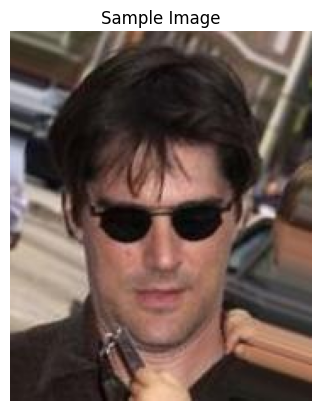

In [ ]:
img = Image.open('/content/classified_images/glasses/000053.jpg')
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()

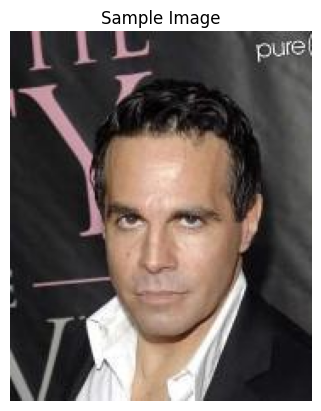

In [ ]:
img = Image.open('/content/classified_images/no_glasses/000008.jpg')
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.title("Sample Image")
plt.show()

In [ ]:
class GlassesDataset(Dataset):
    def __init__(self, path_no_glasses, path_with_glasses, transform=None):
        self.path_A = path_no_glasses  # Domain A: no glasses
        self.path_B = path_with_glasses  # Domain B: with glasses
        self.files_A = sorted([f for f in os.listdir(path_no_glasses) if f.endswith(('.jpg', '.png', '.jpeg'))])
        self.files_B = sorted([f for f in os.listdir(path_with_glasses) if f.endswith(('.jpg', '.png', '.jpeg'))])

        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

    def __getitem__(self, idx):
        idx_B = random.randint(0, len(self.files_B) - 1)  # Random pair for unpaired training

        img_A = Image.open(os.path.join(self.path_A, self.files_A[idx])).convert('RGB')
        img_B = Image.open(os.path.join(self.path_B, self.files_B[idx_B])).convert('RGB')

        return {
            'A': self.transform(img_A),
            'B': self.transform(img_B),
            'A_paths': self.files_A[idx],
            'B_paths': self.files_B[idx_B]
        }

In [ ]:
def prepare_dataset(path_no_glasses, path_with_glasses, preprocessing):
    # Create the dataset
    dataset = GlassesDataset(path_no_glasses, path_with_glasses, preprocessing)

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

    return dataloader


In [ ]:
def setup_training_options(resume_epoch=None):
    opt = TrainOptions()
    # Minimal base args
    base_args = ['colab_kernel_launcher.py', '--dataroot', '']

    # Add specific args for epochs
    base_args.extend(['--n_epochs', '110', '--n_epochs_decay', '1'])  # Total 20 epochs

    # Add other essential args
    base_args.extend([
        '--name', 'glasses_cyclegan',  # Use the same name as your existing checkpoint
        '--model', 'cycle_gan',
        '--dataset_mode', 'unaligned',
        '--batch_size', '1',
        '--load_size', '286',
        '--crop_size', '256',
        '--preprocess', 'resize_and_crop',
        '--no_flip',
        '--display_id', '-1',
        '--checkpoints_dir', '/content/drive/MyDrive/checkpoints',
        '--save_epoch_freq', '1',
        '--save_latest_freq', '1000',
        '--gpu_ids', '0' if torch.cuda.is_available() else '-1'
    ])

    if resume_epoch:
        base_args.extend(['--continue_train', '--epoch_count', str(resume_epoch)])

    sys.argv = base_args
    opt = opt.parse()
    return opt

In [ ]:
def print_trainable_parameters(model):
    print("Trainable/Frozen parameters in netG_A:")
    for name, param in model.netG_A.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
def fine_tune_cyclegan(path_no_glasses, path_with_glasses, resume_epoch=None, test_image_path=None):
    opt = setup_training_options(resume_epoch)
    dataset = GlassesDataset(path_no_glasses, path_with_glasses)
    dataloader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True, num_workers=2)

    model = create_model(opt)
    model.setup(opt)

    total_iters = 0
    total_epochs = opt.n_epochs + opt.n_epochs_decay  # Should be 20
    checkpoint_dir = os.path.join(opt.checkpoints_dir, opt.name)
    os.makedirs(checkpoint_dir, exist_ok=True)

    epoch_bar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"
    iter_bar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"

    # Epoch loop with tqdm
    with tqdm(total=total_epochs, desc="Training Progress", unit="epoch",
              bar_format=epoch_bar_format, initial=opt.epoch_count-1) as epoch_bar:
        for epoch in range(opt.epoch_count, total_epochs + 1):
            model.update_learning_rate()

            with tqdm(total=len(dataloader), desc=f"Epoch {epoch}", unit="batch",
                      bar_format=iter_bar_format, leave=False) as iter_bar:
                for i, data in enumerate(dataloader):
                    model.set_input(data)
                    model.optimize_parameters()
                    total_iters += 1

                    if total_iters % opt.print_freq == 0:
                        losses = model.get_current_losses()
                        tqdm.write(f"Epoch {epoch}/{total_epochs} | Iter {i}/{len(dataloader)} | Losses: {losses}")
                    if total_iters % opt.save_latest_freq == 0:
                        tqdm.write(f"Saving 'latest' checkpoint at iteration {total_iters}")
                        model.save_networks('latest')
                        drive.flush_and_unmount()
                        drive.mount('/content/drive', force_remount=True)

                    iter_bar.update(1)

            # Save checkpoint and show image output
            tqdm.write(f"Saving checkpoint at epoch {epoch}")
            model.save_networks(epoch)
            drive.flush_and_unmount()
            drive.mount('/content/drive', force_remount=True)
            if os.path.exists(os.path.join(checkpoint_dir, f"{epoch}_net_G_A.pth")):
                tqdm.write(f"Checkpoint for epoch {epoch} saved successfully")
            else:
                tqdm.write(f"Warning: Checkpoint for epoch {epoch} not found after save")

            if test_image_path and os.path.exists(test_image_path):
                tqdm.write(f"Generating output for epoch {epoch}")
                output_img = apply_glasses(model, test_image_path)
                tqdm.write(f"Displaying result for epoch {epoch}:")
                display(output_img)

            epoch_bar.update(1)

    tqdm.write("Saving final 'latest' checkpoint")
    model.save_networks('latest')
    drive.flush_and_unmount()
    drive.mount('/content/drive', force_remount=True)
    return model

In [ ]:
def apply_glasses(model, image_path, output_path=None):
    transform = transforms.Compose([
        transforms.Resize(286),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = Image.open(image_path).convert('RGB')
    real_A = transform(img).unsqueeze(0)  # Add batch dimension

    # Create a dummy real_B to satisfy CycleGAN's set_input (not used in inference)
    dummy_B = torch.zeros_like(real_A)

    # Direction AtoB (no-glasses to glasses)
    data = {'A': real_A, 'B': dummy_B, 'A_paths': [image_path], 'B_paths': [image_path]}
    model.set_input(data)
    model.test()  # Generate fake_B from real_A
    result = model.get_current_visuals()['fake_B']
    result_img = util.tensor2im(result)
    result_pil = Image.fromarray(result_img)
    if output_path:
        result_pil.save(output_path)
    return result_pil

In [ ]:
def remove_glasses(model, image_path, output_path=None):
    transform = transforms.Compose([
        transforms.Resize(286),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = Image.open(image_path).convert('RGB')
    real_B = transform(img).unsqueeze(0)  # Input is from glasses domain (B)
    dummy_A = torch.zeros_like(real_B)
    data = {'A': dummy_A, 'B': real_B, 'A_paths': [image_path], 'B_paths': [image_path]}
    model.set_input(data)
    model.test()
    result = model.get_current_visuals()['fake_A']  # Output is no_glasses (A)
    result_img = util.tensor2im(result)
    result_pil = Image.fromarray(result_img)
    if output_path:
        result_pil.save(output_path)
    return result_pil

In [ ]:
path_no_glasses = "/content/classified_images/no_glasses"
path_with_glasses = "/content/classified_images/glasses"
model = fine_tune_cyclegan(
    path_no_glasses=path_no_glasses,
    path_with_glasses=path_with_glasses,
    resume_epoch=111  # نبدأ من Epoch 11 (بعد Epoch 10)
)

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: /content/drive/MyDrive/checkpoints	[default: ./checkpoints]
           continue_train: True                          	[default: False]
                crop_size: 256                           
                 dataroot:                               	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
             

Training Progress:  99%|█████████▉| 110/111 [00:00<?]

learning rate 0.0001000 -> 0.0000000



Epoch 111:   2%|▏         | 98/5000 [00:49<39:23,  2.07batch/s]

Epoch 111:   2%|▏         | 100/5000 [00:50<42:27,  1.92batch/s]

Epoch 111/111 | Iter 99/5000 | Losses: OrderedDict([('D_A', 0.14456316828727722), ('G_A', 0.4165180027484894), ('cycle_A', 0.4106336236000061), ('idt_A', 0.27150726318359375), ('D_B', 0.09390557557344437), ('G_B', 0.6203535199165344), ('cycle_B', 0.676507294178009), ('idt_B', 0.21013480424880981)])



Epoch 111:   4%|▍         | 198/5000 [01:38<39:10,  2.04batch/s]

Epoch 111:   4%|▍         | 200/5000 [01:39<42:14,  1.89batch/s]

Epoch 111/111 | Iter 199/5000 | Losses: OrderedDict([('D_A', 0.30782508850097656), ('G_A', 0.634850800037384), ('cycle_A', 0.5058562159538269), ('idt_A', 0.18123728036880493), ('D_B', 0.17146724462509155), ('G_B', 0.3070531487464905), ('cycle_B', 0.5841929912567139), ('idt_B', 0.2002003788948059)])



Epoch 111:   6%|▌         | 298/5000 [02:27<38:04,  2.06batch/s]

Epoch 111:   6%|▌         | 300/5000 [02:28<41:02,  1.91batch/s]

Epoch 111/111 | Iter 299/5000 | Losses: OrderedDict([('D_A', 0.09284663945436478), ('G_A', 0.6706380248069763), ('cycle_A', 1.0383614301681519), ('idt_A', 0.16595454514026642), ('D_B', 0.0687267854809761), ('G_B', 0.3605782389640808), ('cycle_B', 0.4598507881164551), ('idt_B', 0.3167099356651306)])



Epoch 111:   8%|▊         | 398/5000 [03:15<37:22,  2.05batch/s]

Epoch 111:   8%|▊         | 400/5000 [03:16<40:17,  1.90batch/s]

Epoch 111/111 | Iter 399/5000 | Losses: OrderedDict([('D_A', 0.14966216683387756), ('G_A', 0.5928677320480347), ('cycle_A', 0.71603924036026), ('idt_A', 0.13524973392486572), ('D_B', 0.223241925239563), ('G_B', 0.26827144622802734), ('cycle_B', 0.35319194197654724), ('idt_B', 0.20399659872055054)])



Epoch 111:  10%|▉         | 498/5000 [04:04<36:31,  2.05batch/s]

Epoch 111:  10%|█         | 500/5000 [04:05<39:32,  1.90batch/s]

Epoch 111/111 | Iter 499/5000 | Losses: OrderedDict([('D_A', 0.2263803482055664), ('G_A', 0.42497172951698303), ('cycle_A', 0.4949842095375061), ('idt_A', 0.12943777441978455), ('D_B', 0.09186968952417374), ('G_B', 0.17903867363929749), ('cycle_B', 0.2903444766998291), ('idt_B', 0.23695600032806396)])



Epoch 111:  12%|█▏        | 598/5000 [04:53<35:46,  2.05batch/s]

Epoch 111:  12%|█▏        | 600/5000 [04:54<38:33,  1.90batch/s]

Epoch 111/111 | Iter 599/5000 | Losses: OrderedDict([('D_A', 0.11765656620264053), ('G_A', 0.5188782811164856), ('cycle_A', 0.3567512631416321), ('idt_A', 0.1989630162715912), ('D_B', 0.1538221389055252), ('G_B', 0.42176520824432373), ('cycle_B', 0.6171374917030334), ('idt_B', 0.24493274092674255)])



Epoch 111:  14%|█▍        | 698/5000 [05:41<34:53,  2.06batch/s]

Epoch 111:  14%|█▍        | 700/5000 [05:42<37:40,  1.90batch/s]

Epoch 111/111 | Iter 699/5000 | Losses: OrderedDict([('D_A', 0.10763649642467499), ('G_A', 0.5603266358375549), ('cycle_A', 0.2777503430843353), ('idt_A', 0.1443464308977127), ('D_B', 0.26593345403671265), ('G_B', 0.19629083573818207), ('cycle_B', 0.31007465720176697), ('idt_B', 0.11882857978343964)])



Epoch 111:  16%|█▌        | 798/5000 [06:30<34:03,  2.06batch/s]

Epoch 111:  16%|█▌        | 800/5000 [06:31<36:46,  1.90batch/s]

Epoch 111/111 | Iter 799/5000 | Losses: OrderedDict([('D_A', 0.27936190366744995), ('G_A', 0.44227126240730286), ('cycle_A', 0.5386385321617126), ('idt_A', 0.24508893489837646), ('D_B', 0.21356111764907837), ('G_B', 0.16169878840446472), ('cycle_B', 0.41517359018325806), ('idt_B', 0.2738833725452423)])



Epoch 111:  18%|█▊        | 898/5000 [07:19<33:10,  2.06batch/s]

Epoch 111:  18%|█▊        | 900/5000 [07:20<35:50,  1.91batch/s]

Epoch 111/111 | Iter 899/5000 | Losses: OrderedDict([('D_A', 0.1139298528432846), ('G_A', 0.31301426887512207), ('cycle_A', 0.26705068349838257), ('idt_A', 0.41365087032318115), ('D_B', 0.17107059061527252), ('G_B', 0.45787280797958374), ('cycle_B', 1.0556306838989258), ('idt_B', 0.10340197384357452)])



Epoch 111:  20%|█▉        | 998/5000 [08:07<32:23,  2.06batch/s]

Training Progress:  99%|█████████▉| 110/111 [08:08<?]

Epoch 111:  20%|█▉        | 999/5000 [08:08<32:24,  2.06batch/s]

Epoch 111/111 | Iter 999/5000 | Losses: OrderedDict([('D_A', 0.04329659789800644), ('G_A', 0.4909142553806305), ('cycle_A', 0.6255409121513367), ('idt_A', 0.44815123081207275), ('D_B', 0.13274073600769043), ('G_B', 0.41219279170036316), ('cycle_B', 0.9628894925117493), ('idt_B', 0.24169734120368958)])
Saving 'latest' checkpoint at iteration 1000



Epoch 111:  20%|██        | 1000/5000 [08:32<8:30:38,  7.66s/batch]

Mounted at /content/drive



Epoch 111:  22%|██▏       | 1098/5000 [09:20<31:46,  2.05batch/s]

Epoch 111:  22%|██▏       | 1100/5000 [09:21<34:18,  1.89batch/s]

Epoch 111/111 | Iter 1099/5000 | Losses: OrderedDict([('D_A', 0.21033072471618652), ('G_A', 0.6875351667404175), ('cycle_A', 0.35233423113822937), ('idt_A', 0.13727712631225586), ('D_B', 0.1849750578403473), ('G_B', 0.2849482595920563), ('cycle_B', 0.4107634723186493), ('idt_B', 0.20358684659004211)])



Epoch 111:  24%|██▍       | 1198/5000 [10:09<30:42,  2.06batch/s]

Epoch 111:  24%|██▍       | 1200/5000 [10:10<33:09,  1.91batch/s]

Epoch 111/111 | Iter 1199/5000 | Losses: OrderedDict([('D_A', 0.11487379670143127), ('G_A', 0.27829301357269287), ('cycle_A', 0.3876269459724426), ('idt_A', 0.1203097403049469), ('D_B', 0.2422589659690857), ('G_B', 0.44140124320983887), ('cycle_B', 0.34455329179763794), ('idt_B', 0.16080769896507263)])



Epoch 111:  26%|██▌       | 1298/5000 [10:57<30:02,  2.05batch/s]

Epoch 111:  26%|██▌       | 1300/5000 [10:58<32:23,  1.90batch/s]

Epoch 111/111 | Iter 1299/5000 | Losses: OrderedDict([('D_A', 0.11985702812671661), ('G_A', 0.7857183218002319), ('cycle_A', 0.38541388511657715), ('idt_A', 0.38914477825164795), ('D_B', 0.08696471154689789), ('G_B', 0.2303667962551117), ('cycle_B', 0.3851023018360138), ('idt_B', 0.14175012707710266)])



Epoch 111:  28%|██▊       | 1398/5000 [11:46<29:08,  2.06batch/s]

Epoch 111:  28%|██▊       | 1400/5000 [11:47<31:29,  1.91batch/s]

Epoch 111/111 | Iter 1399/5000 | Losses: OrderedDict([('D_A', 0.13329657912254333), ('G_A', 0.5445865392684937), ('cycle_A', 0.6430047750473022), ('idt_A', 0.1761886179447174), ('D_B', 0.3443203568458557), ('G_B', 0.11494550853967667), ('cycle_B', 0.4264340400695801), ('idt_B', 0.23215323686599731)])



Epoch 111:  30%|██▉       | 1498/5000 [12:35<28:20,  2.06batch/s]

Epoch 111:  30%|███       | 1500/5000 [12:36<30:34,  1.91batch/s]

Epoch 111/111 | Iter 1499/5000 | Losses: OrderedDict([('D_A', 0.21931029856204987), ('G_A', 0.2923329770565033), ('cycle_A', 0.6536164283752441), ('idt_A', 0.1179899200797081), ('D_B', 0.26234233379364014), ('G_B', 0.2095264047384262), ('cycle_B', 0.3713870048522949), ('idt_B', 0.3022559881210327)])



Epoch 111:  32%|███▏      | 1598/5000 [13:23<27:33,  2.06batch/s]

Epoch 111:  32%|███▏      | 1600/5000 [13:24<29:46,  1.90batch/s]

Epoch 111/111 | Iter 1599/5000 | Losses: OrderedDict([('D_A', 0.2443481981754303), ('G_A', 0.4417755901813507), ('cycle_A', 0.47465986013412476), ('idt_A', 0.27922552824020386), ('D_B', 0.14809510111808777), ('G_B', 0.35653674602508545), ('cycle_B', 0.5057975053787231), ('idt_B', 0.23118633031845093)])



Epoch 111:  34%|███▍      | 1698/5000 [14:12<26:43,  2.06batch/s]

Epoch 111:  34%|███▍      | 1700/5000 [14:13<28:49,  1.91batch/s]

Epoch 111/111 | Iter 1699/5000 | Losses: OrderedDict([('D_A', 0.15869663655757904), ('G_A', 0.40407130122184753), ('cycle_A', 0.48953020572662354), ('idt_A', 0.1757010668516159), ('D_B', 0.12557333707809448), ('G_B', 0.4620646834373474), ('cycle_B', 0.4397674798965454), ('idt_B', 0.20795214176177979)])



Epoch 111:  36%|███▌      | 1798/5000 [15:01<25:53,  2.06batch/s]

Epoch 111:  36%|███▌      | 1800/5000 [15:02<27:58,  1.91batch/s]

Epoch 111/111 | Iter 1799/5000 | Losses: OrderedDict([('D_A', 0.22357702255249023), ('G_A', 0.4967440962791443), ('cycle_A', 0.5342972278594971), ('idt_A', 0.3061504662036896), ('D_B', 0.27436408400535583), ('G_B', 0.2089853733778), ('cycle_B', 0.6844156980514526), ('idt_B', 0.3255513310432434)])



Epoch 111:  38%|███▊      | 1898/5000 [15:49<25:09,  2.06batch/s]

Epoch 111:  38%|███▊      | 1900/5000 [15:50<27:06,  1.91batch/s]

Epoch 111/111 | Iter 1899/5000 | Losses: OrderedDict([('D_A', 0.11270004510879517), ('G_A', 0.1572009027004242), ('cycle_A', 0.2917359471321106), ('idt_A', 0.19780544936656952), ('D_B', 0.08856194466352463), ('G_B', 0.5800371766090393), ('cycle_B', 0.5104897022247314), ('idt_B', 0.17574864625930786)])



Epoch 111:  40%|███▉      | 1998/5000 [16:38<24:22,  2.05batch/s]

Training Progress:  99%|█████████▉| 110/111 [16:39<?]

Epoch 111:  40%|███▉      | 1999/5000 [16:39<24:20,  2.05batch/s]

Epoch 111/111 | Iter 1999/5000 | Losses: OrderedDict([('D_A', 0.24421632289886475), ('G_A', 0.8089616894721985), ('cycle_A', 0.970919132232666), ('idt_A', 0.13914591073989868), ('D_B', 0.15174704790115356), ('G_B', 0.34694772958755493), ('cycle_B', 0.6824216246604919), ('idt_B', 0.3367546796798706)])
Saving 'latest' checkpoint at iteration 2000



Epoch 111:  40%|████      | 2000/5000 [17:01<5:56:06,  7.12s/batch]

Mounted at /content/drive



Epoch 111:  42%|████▏     | 2098/5000 [17:49<23:42,  2.04batch/s]

Epoch 111:  42%|████▏     | 2100/5000 [17:50<25:31,  1.89batch/s]

Epoch 111/111 | Iter 2099/5000 | Losses: OrderedDict([('D_A', 0.11509829759597778), ('G_A', 0.5620774626731873), ('cycle_A', 0.33185094594955444), ('idt_A', 0.11394830048084259), ('D_B', 0.18653075397014618), ('G_B', 0.27499741315841675), ('cycle_B', 0.466605544090271), ('idt_B', 0.14590643346309662)])



Epoch 111:  44%|████▍     | 2198/5000 [18:38<22:39,  2.06batch/s]

Epoch 111:  44%|████▍     | 2200/5000 [18:39<24:33,  1.90batch/s]

Epoch 111/111 | Iter 2199/5000 | Losses: OrderedDict([('D_A', 0.1396801471710205), ('G_A', 0.39443856477737427), ('cycle_A', 0.3332808315753937), ('idt_A', 0.11460579186677933), ('D_B', 0.16450713574886322), ('G_B', 0.26225051283836365), ('cycle_B', 0.3706769347190857), ('idt_B', 0.14499205350875854)])



Epoch 111:  46%|████▌     | 2298/5000 [19:26<21:49,  2.06batch/s]

Epoch 111:  46%|████▌     | 2300/5000 [19:28<23:32,  1.91batch/s]

Epoch 111/111 | Iter 2299/5000 | Losses: OrderedDict([('D_A', 0.17308571934700012), ('G_A', 0.4576531946659088), ('cycle_A', 0.38574135303497314), ('idt_A', 0.21905285120010376), ('D_B', 0.2031252086162567), ('G_B', 0.2327982634305954), ('cycle_B', 0.5821832418441772), ('idt_B', 0.13351115584373474)])



Epoch 111:  48%|████▊     | 2398/5000 [20:15<21:06,  2.06batch/s]

Epoch 111:  48%|████▊     | 2400/5000 [20:16<22:46,  1.90batch/s]

Epoch 111/111 | Iter 2399/5000 | Losses: OrderedDict([('D_A', 0.16586101055145264), ('G_A', 0.6075732707977295), ('cycle_A', 0.36754342913627625), ('idt_A', 0.1363885998725891), ('D_B', 0.15768706798553467), ('G_B', 0.3104479908943176), ('cycle_B', 0.3794804811477661), ('idt_B', 0.14705790579319)])



Epoch 111:  50%|████▉     | 2498/5000 [21:04<20:18,  2.05batch/s]

Epoch 111:  50%|█████     | 2500/5000 [21:05<21:55,  1.90batch/s]

Epoch 111/111 | Iter 2499/5000 | Losses: OrderedDict([('D_A', 0.22554397583007812), ('G_A', 0.537236750125885), ('cycle_A', 0.2329983115196228), ('idt_A', 0.13424383103847504), ('D_B', 0.16706550121307373), ('G_B', 0.2689416706562042), ('cycle_B', 0.3093472123146057), ('idt_B', 0.09284533560276031)])



Epoch 111:  52%|█████▏    | 2598/5000 [21:52<19:25,  2.06batch/s]

Epoch 111:  52%|█████▏    | 2600/5000 [21:53<20:56,  1.91batch/s]

Epoch 111/111 | Iter 2599/5000 | Losses: OrderedDict([('D_A', 0.1126917153596878), ('G_A', 0.626372218132019), ('cycle_A', 0.5031564831733704), ('idt_A', 0.1480078548192978), ('D_B', 0.23339076340198517), ('G_B', 0.474128782749176), ('cycle_B', 0.41016608476638794), ('idt_B', 0.3196181356906891)])



Epoch 111:  54%|█████▍    | 2698/5000 [22:41<18:41,  2.05batch/s]

Epoch 111:  54%|█████▍    | 2700/5000 [22:42<20:07,  1.90batch/s]

Epoch 111/111 | Iter 2699/5000 | Losses: OrderedDict([('D_A', 0.10755801200866699), ('G_A', 0.505517840385437), ('cycle_A', 0.3443613648414612), ('idt_A', 0.12858043611049652), ('D_B', 0.2562444508075714), ('G_B', 0.2862594425678253), ('cycle_B', 0.34809353947639465), ('idt_B', 0.1256369650363922)])



Epoch 111:  56%|█████▌    | 2798/5000 [23:30<17:49,  2.06batch/s]

Epoch 111:  56%|█████▌    | 2800/5000 [23:31<19:12,  1.91batch/s]

Epoch 111/111 | Iter 2799/5000 | Losses: OrderedDict([('D_A', 0.16861440241336823), ('G_A', 0.36401334404945374), ('cycle_A', 0.4346354007720947), ('idt_A', 0.4562629461288452), ('D_B', 0.19203542172908783), ('G_B', 0.28368961811065674), ('cycle_B', 1.0196202993392944), ('idt_B', 0.20735083520412445)])



Epoch 111:  58%|█████▊    | 2898/5000 [24:18<17:00,  2.06batch/s]

Epoch 111:  58%|█████▊    | 2900/5000 [24:19<18:21,  1.91batch/s]

Epoch 111/111 | Iter 2899/5000 | Losses: OrderedDict([('D_A', 0.08715517818927765), ('G_A', 0.7281869053840637), ('cycle_A', 0.4102250933647156), ('idt_A', 0.12859074771404266), ('D_B', 0.07435908913612366), ('G_B', 0.6273370981216431), ('cycle_B', 0.32386845350265503), ('idt_B', 0.15843883156776428)])



Epoch 111:  60%|█████▉    | 2998/5000 [25:07<16:11,  2.06batch/s]

Training Progress:  99%|█████████▉| 110/111 [25:08<?]

Epoch 111:  60%|█████▉    | 2999/5000 [25:08<16:11,  2.06batch/s]

Epoch 111/111 | Iter 2999/5000 | Losses: OrderedDict([('D_A', 0.18448185920715332), ('G_A', 0.48416200280189514), ('cycle_A', 0.49309951066970825), ('idt_A', 0.17804093658924103), ('D_B', 0.15141618251800537), ('G_B', 0.42583781480789185), ('cycle_B', 0.4777298867702484), ('idt_B', 0.12939676642417908)])
Saving 'latest' checkpoint at iteration 3000



Epoch 111:  60%|██████    | 3000/5000 [25:32<4:15:12,  7.66s/batch]

Mounted at /content/drive



Epoch 111:  62%|██████▏   | 3098/5000 [26:20<15:35,  2.03batch/s]

Epoch 111:  62%|██████▏   | 3100/5000 [26:21<16:47,  1.89batch/s]

Epoch 111/111 | Iter 3099/5000 | Losses: OrderedDict([('D_A', 0.21967560052871704), ('G_A', 0.3405664265155792), ('cycle_A', 0.29608485102653503), ('idt_A', 0.2753518223762512), ('D_B', 0.1934480220079422), ('G_B', 0.27736231684684753), ('cycle_B', 0.630109429359436), ('idt_B', 0.12574315071105957)])



Epoch 111:  64%|██████▍   | 3198/5000 [27:08<14:33,  2.06batch/s]

Epoch 111:  64%|██████▍   | 3200/5000 [27:09<15:42,  1.91batch/s]

Epoch 111/111 | Iter 3199/5000 | Losses: OrderedDict([('D_A', 0.18394878506660461), ('G_A', 0.22129486501216888), ('cycle_A', 0.31167057156562805), ('idt_A', 0.13604736328125), ('D_B', 0.3544173538684845), ('G_B', 0.45604321360588074), ('cycle_B', 0.4053025245666504), ('idt_B', 0.14218999445438385)])



Epoch 111:  66%|██████▌   | 3298/5000 [27:57<13:46,  2.06batch/s]

Epoch 111:  66%|██████▌   | 3300/5000 [27:58<14:54,  1.90batch/s]

Epoch 111/111 | Iter 3299/5000 | Losses: OrderedDict([('D_A', 0.1464950442314148), ('G_A', 0.4384361505508423), ('cycle_A', 0.6688132286071777), ('idt_A', 0.13564738631248474), ('D_B', 0.28155794739723206), ('G_B', 0.3617800772190094), ('cycle_B', 0.4351380169391632), ('idt_B', 0.4514005780220032)])



Epoch 111:  68%|██████▊   | 3398/5000 [28:45<13:00,  2.05batch/s]

Epoch 111:  68%|██████▊   | 3400/5000 [28:47<14:01,  1.90batch/s]

Epoch 111/111 | Iter 3399/5000 | Losses: OrderedDict([('D_A', 0.2571858763694763), ('G_A', 0.38867053389549255), ('cycle_A', 0.3785434067249298), ('idt_A', 0.2712497115135193), ('D_B', 0.2429639995098114), ('G_B', 0.21903297305107117), ('cycle_B', 0.4140855073928833), ('idt_B', 0.16096629202365875)])



Epoch 111:  70%|██████▉   | 3498/5000 [29:34<12:10,  2.06batch/s]

Epoch 111:  70%|███████   | 3500/5000 [29:35<13:07,  1.90batch/s]

Epoch 111/111 | Iter 3499/5000 | Losses: OrderedDict([('D_A', 0.15537454187870026), ('G_A', 0.3982563614845276), ('cycle_A', 0.3844928443431854), ('idt_A', 0.12216551601886749), ('D_B', 0.2323848456144333), ('G_B', 0.21166454255580902), ('cycle_B', 0.48555588722229004), ('idt_B', 0.1881881207227707)])



Epoch 111:  72%|███████▏  | 3598/5000 [30:23<11:22,  2.05batch/s]

Epoch 111:  72%|███████▏  | 3600/5000 [30:24<12:16,  1.90batch/s]

Epoch 111/111 | Iter 3599/5000 | Losses: OrderedDict([('D_A', 0.22494253516197205), ('G_A', 0.29421985149383545), ('cycle_A', 0.4783669114112854), ('idt_A', 0.146382138133049), ('D_B', 0.21041983366012573), ('G_B', 0.3337159752845764), ('cycle_B', 0.3757421672344208), ('idt_B', 0.2035798728466034)])



Epoch 111:  74%|███████▍  | 3698/5000 [31:12<10:32,  2.06batch/s]

Epoch 111:  74%|███████▍  | 3700/5000 [31:13<11:22,  1.90batch/s]

Epoch 111/111 | Iter 3699/5000 | Losses: OrderedDict([('D_A', 0.1346893012523651), ('G_A', 0.5121480226516724), ('cycle_A', 0.41593119502067566), ('idt_A', 0.12033356726169586), ('D_B', 0.2733522355556488), ('G_B', 0.21141059696674347), ('cycle_B', 0.37125295400619507), ('idt_B', 0.19145599007606506)])



Epoch 111:  76%|███████▌  | 3798/5000 [32:00<09:44,  2.06batch/s]

Epoch 111:  76%|███████▌  | 3800/5000 [32:01<10:30,  1.90batch/s]

Epoch 111/111 | Iter 3799/5000 | Losses: OrderedDict([('D_A', 0.09608769416809082), ('G_A', 0.6659674644470215), ('cycle_A', 0.33707332611083984), ('idt_A', 0.2219218760728836), ('D_B', 0.08413150906562805), ('G_B', 0.42390379309654236), ('cycle_B', 0.5754692554473877), ('idt_B', 0.16682839393615723)])



Epoch 111:  78%|███████▊  | 3898/5000 [32:49<08:55,  2.06batch/s]

Epoch 111:  78%|███████▊  | 3900/5000 [32:50<09:36,  1.91batch/s]

Epoch 111/111 | Iter 3899/5000 | Losses: OrderedDict([('D_A', 0.07353335618972778), ('G_A', 0.6253765225410461), ('cycle_A', 0.5337579250335693), ('idt_A', 0.12338544428348541), ('D_B', 0.13551130890846252), ('G_B', 0.4934467077255249), ('cycle_B', 0.3748945891857147), ('idt_B', 0.24802042543888092)])



Epoch 111:  80%|███████▉  | 3998/5000 [33:38<08:08,  2.05batch/s]

Training Progress:  99%|█████████▉| 110/111 [33:39<?]

Epoch 111:  80%|███████▉  | 3999/5000 [33:39<08:07,  2.05batch/s]

Epoch 111/111 | Iter 3999/5000 | Losses: OrderedDict([('D_A', 0.05493081361055374), ('G_A', 0.5570309162139893), ('cycle_A', 0.471294641494751), ('idt_A', 0.3052796423435211), ('D_B', 0.13211236894130707), ('G_B', 0.4135568141937256), ('cycle_B', 0.5420607328414917), ('idt_B', 0.16145986318588257)])
Saving 'latest' checkpoint at iteration 4000



Epoch 111:  80%|████████  | 4000/5000 [34:00<1:57:36,  7.06s/batch]

Mounted at /content/drive



Epoch 111:  82%|████████▏ | 4098/5000 [34:49<07:20,  2.05batch/s]

Epoch 111:  82%|████████▏ | 4100/5000 [34:50<07:55,  1.89batch/s]

Epoch 111/111 | Iter 4099/5000 | Losses: OrderedDict([('D_A', 0.10648777335882187), ('G_A', 0.26782286167144775), ('cycle_A', 0.355449378490448), ('idt_A', 0.1289999634027481), ('D_B', 0.16746430099010468), ('G_B', 0.4160113036632538), ('cycle_B', 0.3069060742855072), ('idt_B', 0.2265813648700714)])



Epoch 111:  84%|████████▍ | 4198/5000 [35:37<06:28,  2.06batch/s]

Epoch 111:  84%|████████▍ | 4200/5000 [35:38<06:58,  1.91batch/s]

Epoch 111/111 | Iter 4199/5000 | Losses: OrderedDict([('D_A', 0.1603279709815979), ('G_A', 0.5551133155822754), ('cycle_A', 0.4362465441226959), ('idt_A', 0.18443211913108826), ('D_B', 0.2520869970321655), ('G_B', 0.3495804965496063), ('cycle_B', 0.3307027816772461), ('idt_B', 0.20515306293964386)])



Epoch 111:  86%|████████▌ | 4298/5000 [36:26<05:41,  2.06batch/s]

Epoch 111:  86%|████████▌ | 4300/5000 [36:27<06:09,  1.90batch/s]

Epoch 111/111 | Iter 4299/5000 | Losses: OrderedDict([('D_A', 0.16757427155971527), ('G_A', 0.6305463314056396), ('cycle_A', 0.6734693646430969), ('idt_A', 0.15129593014717102), ('D_B', 0.28674614429473877), ('G_B', 0.4840754568576813), ('cycle_B', 0.3397992253303528), ('idt_B', 0.2366199791431427)])



Epoch 111:  88%|████████▊ | 4398/5000 [37:14<04:52,  2.06batch/s]

Epoch 111:  88%|████████▊ | 4400/5000 [37:15<05:15,  1.90batch/s]

Epoch 111/111 | Iter 4399/5000 | Losses: OrderedDict([('D_A', 0.1154475286602974), ('G_A', 0.5121200084686279), ('cycle_A', 0.409026175737381), ('idt_A', 0.12033352255821228), ('D_B', 0.2374390959739685), ('G_B', 0.21141080558300018), ('cycle_B', 0.3712529242038727), ('idt_B', 0.46401962637901306)])



Epoch 111:  90%|████████▉ | 4498/5000 [38:03<04:04,  2.06batch/s]

Epoch 111:  90%|█████████ | 4500/5000 [38:04<04:22,  1.90batch/s]

Epoch 111/111 | Iter 4499/5000 | Losses: OrderedDict([('D_A', 0.13072934746742249), ('G_A', 0.9061190485954285), ('cycle_A', 0.3774062395095825), ('idt_A', 0.12698781490325928), ('D_B', 0.25554338097572327), ('G_B', 0.15352268517017365), ('cycle_B', 0.33038973808288574), ('idt_B', 0.17496821284294128)])



Epoch 111:  92%|█████████▏| 4598/5000 [38:52<03:15,  2.05batch/s]

Epoch 111:  92%|█████████▏| 4600/5000 [38:53<03:30,  1.90batch/s]

Epoch 111/111 | Iter 4599/5000 | Losses: OrderedDict([('D_A', 0.07806536555290222), ('G_A', 0.6181271076202393), ('cycle_A', 0.5811668634414673), ('idt_A', 0.1786470115184784), ('D_B', 0.12508440017700195), ('G_B', 0.660509467124939), ('cycle_B', 0.4574991464614868), ('idt_B', 0.14026786386966705)])



Epoch 111:  94%|█████████▍| 4698/5000 [39:41<02:27,  2.05batch/s]

Epoch 111:  94%|█████████▍| 4700/5000 [39:42<02:38,  1.89batch/s]

Epoch 111/111 | Iter 4699/5000 | Losses: OrderedDict([('D_A', 0.1929853856563568), ('G_A', 0.5516838431358337), ('cycle_A', 0.35157978534698486), ('idt_A', 0.3786919116973877), ('D_B', 0.1830911785364151), ('G_B', 0.1546085625886917), ('cycle_B', 0.519351065158844), ('idt_B', 0.15296992659568787)])



Epoch 111:  96%|█████████▌| 4798/5000 [40:29<01:38,  2.06batch/s]

Epoch 111:  96%|█████████▌| 4800/5000 [40:30<01:45,  1.90batch/s]

Epoch 111/111 | Iter 4799/5000 | Losses: OrderedDict([('D_A', 0.2036815881729126), ('G_A', 0.5332158803939819), ('cycle_A', 0.6231400370597839), ('idt_A', 0.20393572747707367), ('D_B', 0.20771238207817078), ('G_B', 0.2323969304561615), ('cycle_B', 0.41501468420028687), ('idt_B', 0.33389371633529663)])



Epoch 111:  98%|█████████▊| 4898/5000 [41:18<00:49,  2.06batch/s]

Epoch 111:  98%|█████████▊| 4900/5000 [41:19<00:52,  1.90batch/s]

Epoch 111/111 | Iter 4899/5000 | Losses: OrderedDict([('D_A', 0.10701535642147064), ('G_A', 0.6142808794975281), ('cycle_A', 0.4379090666770935), ('idt_A', 0.16200712323188782), ('D_B', 0.13619264960289001), ('G_B', 0.42237281799316406), ('cycle_B', 0.4812452793121338), ('idt_B', 0.19877585768699646)])



Epoch 111: 100%|█████████▉| 4998/5000 [42:07<00:00,  2.06batch/s]

Training Progress:  99%|█████████▉| 110/111 [42:08<?]

Epoch 111: 100%|█████████▉| 4999/5000 [42:08<00:00,  2.06batch/s]

Epoch 111/111 | Iter 4999/5000 | Losses: OrderedDict([('D_A', 0.07929524779319763), ('G_A', 0.6810547113418579), ('cycle_A', 0.5202152729034424), ('idt_A', 0.1836601048707962), ('D_B', 0.1719568520784378), ('G_B', 0.25727716088294983), ('cycle_B', 0.45536381006240845), ('idt_B', 0.12543879449367523)])
Saving 'latest' checkpoint at iteration 5000



Training Progress:  99%|█████████▉| 110/111 [42:56<?]

Mounted at /content/drive
Saving checkpoint at epoch 111


Training Progress: 100%|██████████| 111/111 [45:03<00:00]

Mounted at /content/drive
Checkpoint for epoch 111 saved successfully
Saving final 'latest' checkpoint


Mounted at /content/drive


In [ ]:
test_image = "/content/drive/MyDrive/012972.jpg"
result = apply_glasses(model, test_image, "output_with_glasses.jpg")

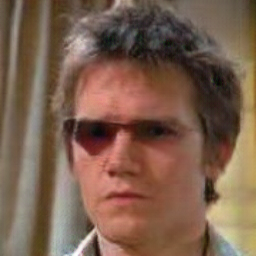

In [ ]:
display(result)

In [ ]:
test_image = "/content/classified_images/no_glasses/000954.jpg"
result2 = apply_glasses(model, test_image, "output_without_glasses.jpg")

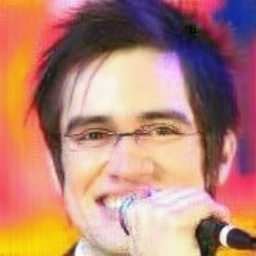

In [ ]:
result2

In [ ]:
test_image = "/content/classified_images/no_glasses/000961.jpg"
result3 = apply_glasses(model, test_image, "output_without_glasses.jpg")

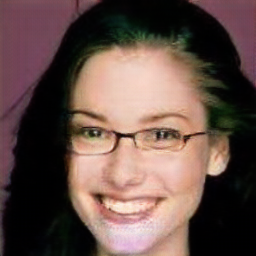

In [ ]:
result3

In [ ]:
test_image4 = "/content/WhatsApp Image 2025-04-22 at 23.14.07_c23d7c89.jpg"
result4 = apply_glasses(model, test_image4, "output_without_glasses.jpg")

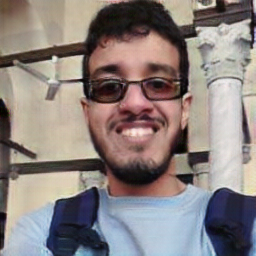

In [ ]:
result4

In [ ]:
test_image5 = "/content/WhatsApp Image 2025-04-22 at 23.57.17_a8f846a6.jpg"
result5 =  apply_glasses(model, test_image5, "output_without_glasses1.jpg")

FileNotFoundError: [Errno 2] No such file or directory: '/content/WhatsApp Image 2025-04-22 at 23.57.17_a8f846a6.jpg'

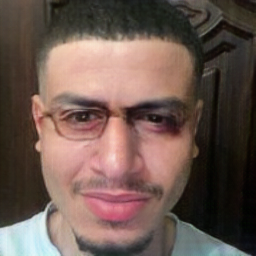

In [ ]:
result5

In [ ]:
test_image = "/content/classified_images/glasses/000310.jpg"
result5 = remove_glasses(model, test_image, "output_without_glasses.jpg")

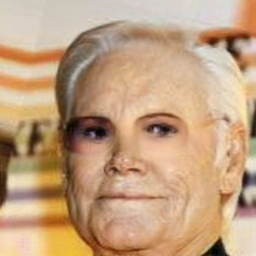

In [ ]:
result5

In [ ]:
'''if __name__ == "__main__":
    path_no_glasses = "/content/classified_images/no_glasses"
    path_with_glasses = "/content/classified_images/glasses"
    pretrained_path = "./checkpoints/horse2zebra_pretrained/latest_net_G.pth"

    if not os.path.exists(path_no_glasses) or not os.path.exists(path_with_glasses):
        raise FileNotFoundError("Dataset paths not found. Please prepare your data first.")
    if not os.path.exists(pretrained_path):
        raise FileNotFoundError(f"Pretrained model not found at {pretrained_path}. Please download it.")

    model = fine_tune_cyclegan(path_no_glasses, path_with_glasses, pretrained_path, resume_epoch=10)'''

TypeError: fine_tune_cyclegan() got multiple values for argument 'resume_epoch'

In [ ]:
'''import os
checkpoint_base = '/content/drive/MyDrive/checkpoints'
print(f"Base checkpoint directory exists: {os.path.exists(checkpoint_base)}")
if os.path.exists(checkpoint_base):
    print(f"Contents of {checkpoint_base}: {os.listdir(checkpoint_base)}")

    # Check if glasses_cyclegan directory exists
    glasses_dir = os.path.join(checkpoint_base, 'glasses_cyclegan')
    if os.path.exists(glasses_dir):
        print(f"Contents of {glasses_dir}: {os.listdir(glasses_dir)}")'''

Base checkpoint directory exists: True
Contents of /content/drive/MyDrive/checkpoints: ['glasses_cyclegan', 'experiment_name']
Contents of /content/drive/MyDrive/checkpoints/glasses_cyclegan: ['1_net_G_A.pth', '1_net_G_B.pth', '1_net_D_A.pth', '1_net_D_B.pth', '2_net_G_A.pth', '2_net_G_B.pth', '2_net_D_A.pth', '2_net_D_B.pth', '3_net_G_A.pth', '3_net_G_B.pth', '3_net_D_A.pth', '3_net_D_B.pth', '4_net_G_A.pth', '4_net_G_B.pth', '4_net_D_A.pth', '4_net_D_B.pth', '5_net_G_A.pth', '5_net_G_B.pth', '5_net_D_A.pth', '5_net_D_B.pth', '6_net_G_A.pth', '6_net_G_B.pth', '6_net_D_A.pth', '6_net_D_B.pth', '7_net_G_A.pth', '7_net_G_B.pth', '7_net_D_A.pth', '7_net_D_B.pth', '8_net_G_A.pth', '8_net_G_B.pth', '8_net_D_A.pth', '8_net_D_B.pth', '9_net_G_A.pth', '9_net_G_B.pth', '9_net_D_A.pth', '9_net_D_B.pth', '10_net_G_A.pth', '10_net_G_B.pth', '10_net_D_A.pth', '10_net_D_B.pth', 'latest_net_D_A.pth', 'latest_net_G_A.pth', 'latest_net_D_B.pth', 'latest_net_G_B.pth', 'train_opt.txt']
